# SnapATAC Peak Matrix Analysis

Using data processed by Laksshman, pmat using peaks from day-wise bulk + cluster-wise bulk combined. ChromVAR analysis as well.

**NOTE**: As of 6 Feb, the pmat are attached to snap files only at `/srv/scratch`. Moreover, the pmat attached using SnapTools most likely counts fragments in peaks. For correctness, we should count Tn5 shifted 5' ends of reads in peaks.

In [1]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2) 
library(scales)
library(RColorBrewer)

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums


The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapp

In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [3]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"
BARCODES_PREFIX = "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25/"

file.list = c()
barcode.file.list = c()

for (d in DAYS) {
    file.list = c(file.list, sprintf("%s/%s.snap", FILE_PREFIX, d))
    barcode.file.list = c(barcode.file.list, sprintf("%s/%s.barcodes.txt", BARCODES_PREFIX, d))
}
DAYS
file.list
barcode.file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

[1] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D0.barcodes.txt" 
[2] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D2.barcodes.txt" 
[3] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D4.barcodes.txt" 
[4] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D6.barcodes.txt" 
[5] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D8.barcodes.txt" 
[6] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D10.barcodes.txt"
[7] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D12.barcodes.txt"
[8] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25//D14.barcodes.txt"

In [5]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [6]:
# Filter cells using previously selected barcodes (see BarcodeSelection.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = DAYS;

In [8]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [9]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [10]:
x.sp

number of barcodes: 55320
number of bins: 0
number of genes: 0
number of peaks: 414632
number of motifs: 0

In [11]:
dim(x.sp@pmat)

[1]  55320 414632

In [12]:
rm(x.sp.list); # free memory
gc()

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   4365291  233.2    7699518   411.2    5864348   313.2
Vcells 539388533 4115.3 2051070766 15648.5 1547286054 11804.9

In [13]:
# check if reads at OCT promoter (very few or none in initial version)
sum(x.sp@pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), x.sp@peak))])

[1] 7559

In [21]:
# filter out cells in clump from metadata (cluster 15) 
# or iPSC (cluster 16, removing these are likely artifacts and are very few)
metadata = read.table("../20200122_snapATAC/snapATAC_sessions/20201020_n62402/metadata.tsv", header=T)
head(metadata)

clump_barcodes = paste(metadata$sample, metadata$barcode, sep='_')[(metadata$cluster==15)|(metadata$cluster==16)]
length(clump_barcodes)

barcode          TN    UM    PP    UQ    CM landmark cluster umap1    
1 AAACAACGACGATTAC 53446 53446 53446 53379 0  1         5       8.406578
2 AAACACGCTCCTCAAA  3238  3238  3238  3238 0  1         5      11.262834
3 AAACACGCTTAACGAA  2110  2110  2110  2108 0  1         5      11.342345
4 AAACATGGAGACTCGC 24362 24362 24362 24345 0  1        11       6.358692
5 AAACCCTGAGTACACT 12752 12752 12752 12748 0  1         5      10.147214
6 AAACGAAACCTGGAAG 14970 14970 14970 14955 0  1         5       9.941466
  umap2      sample
1 -0.8157006 D0    
2 -1.7979238 D0    
3 -1.8858316 D0    
4 -2.3480776 D0    
5 -3.1927453 D0    
6 -0.9439331 D0

[1] 8487

In [23]:
# as noted above, only 7 cells from D14 fall in iPSC cluster 
# can remove those as being artifacts
table(metadata[metadata$cluster==16, "sample"])


  D0  D10  D12  D14   D2   D4   D6   D8   H1 
   0    0    0    7    0    0    0    0 7010 

In [26]:
x.sp = x.sp[!paste(x.sp@sample, x.sp@barcode, sep='_') %in% clump_barcodes,]

In [ ]:
# or remove cells not present in another list
# metadata = read.table("./sessions/20200220_n74838/metadata.tsv", header=T)

# x.sp = x.sp[paste(x.sp@sample, x.sp@barcode, sep='_') %in% rownames(metadata), ]

In [27]:
x.sp

number of barcodes: 53906
number of bins: 0
number of genes: 0
number of peaks: 414632
number of motifs: 0

In [28]:
x.sp = makeBinary(x.sp, mat="pmat");

In [ ]:
# tempCov = Matrix::rowSums(x.sp@pmat)
# quantile(tempCov, c(0.995))

In [ ]:
# remove barcodes with too many bins (outliers)
# x.sp = x.sp[tempCov<quantile(tempCov, c(0.995)), , mat="pmat"]
# x.sp

In [29]:
x.sp

number of barcodes: 53906
number of bins: 0
number of genes: 0
number of peaks: 414632
number of motifs: 0

## Filtering bins

In [30]:
black_list = read.table("../../../resources/blacklist/GRch38_unified_blacklist.bed");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [31]:
idy = queryHits(findOverlaps(x.sp@peak, black_list.gr));

In [32]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [33]:
# chr.exclude = seqlevels(x.sp@peak)[grep("random|chrM|chrUn", seqlevels(x.sp@peak))];
# idy = grep(paste(chr.exclude, collapse="|"), x.sp@peak);
# if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [34]:
x.sp

number of barcodes: 53906
number of bins: 0
number of genes: 0
number of peaks: 414473
number of motifs: 0

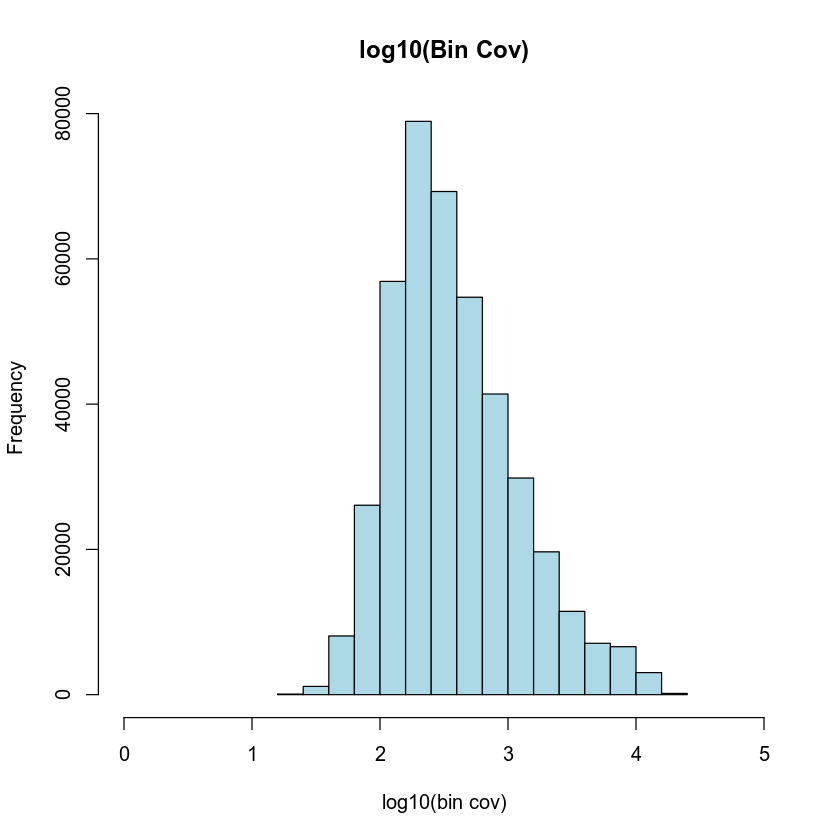

In [35]:
bin.cov = log10(Matrix::colSums(x.sp@pmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);

In [36]:
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="pmat"];
x.sp

number of barcodes: 53906
number of bins: 0
number of genes: 0
number of peaks: 393750
number of motifs: 0

## Dim Reduction 

In [37]:
rowCovs = Matrix::rowSums(x.sp@pmat)

In [38]:
table(x.sp@sample)


   D0   D10   D12   D14    D2    D4    D6    D8 
10819  1405  2872 12654  6226  5463  7328  7139 

In [39]:
row.covs = log10(rowCovs+1);

LANDMARKS_PER_DAY = 1400 # ceiling(10000/length(DAYS))
row.covs.dens = density(
    x = row.covs, 
    bw = 'nrd', adjust = 1
  );
sampling_prob = 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps); 

In [138]:
set.seed(1);
idx.landmark.ds = c()

for (d in DAYS) {
    idx.landmark.ds = c(idx.landmark.ds, 
                        sample(x = which(x.sp@sample==d), size = LANDMARKS_PER_DAY, prob = sampling_prob[which(x.sp@sample==d)])
                       )
}

# OR sample from all
# idx.landmark.ds = sample(x = seq(nrow(x.sp)), size=15000, prob=sampling_prob)

idx.landmark.ds = sort(idx.landmark.ds);
x.landmark.sp = x.sp[idx.landmark.ds,];
x.query.sp = x.sp[-idx.landmark.ds,];

In [139]:
table(x.landmark.sp@sample)


  D0  D10  D12  D14   D2   D4   D6   D8 
1400 1400 1400 1400 1400 1400 1400 1400 

In [140]:
# DID NOT PREVIOUSLY WORK OUT OF THE BOX SINCE bmat was hardcoded in trainRegression
# there was also a typo in runLDM.R last line of runDiffusionMapsExtension
# Changed it in my version /users/surag/software/R_packages/SnapATAC
# TODO: version control this version!

In [141]:
x.landmark.sp = runDiffusionMaps(
    obj= x.landmark.sp,
    input.mat="pmat", 
    num.eigs=50
);

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



In [142]:
x.query.sp = runDiffusionMapsExtension(
    obj1=x.landmark.sp, 
    obj2=x.query.sp,
    input.mat="pmat"
  );

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: performing normalization ...

Epoch: projecting query cells to the reference ...

Epoch: Done



In [143]:
x.landmark.sp@metaData$landmark = 1;
x.query.sp@metaData$landmark = 0;
x.sp = snapRbind(x.landmark.sp, x.query.sp);
## combine landmarks and query cells;
x.sp = x.sp[order(x.sp@sample),]; # IMPORTANT

# IMP: recompute since order has changed
rowCovs = Matrix::rowSums(x.sp@pmat)

In [144]:
max(x.landmark.sp@jmat@nmat)

[1] 3.151572

In [145]:
quantile(as.vector(x.landmark.sp@jmat@nmat), 0.99)

99% 
2.151942

## PCA on NMAT

In [89]:
nmat = rbind(x.landmark.sp@jmat@nmat, x.query.sp@jmat@nmat)
rownames(nmat) = c(paste(x.landmark.sp@sample, x.landmark.sp@barcode, sep='_'), 
                  paste(x.query.sp@sample, x.query.sp@barcode, sep='_'))

In [90]:
dim(nmat)

[1] 53906 11200

In [91]:
pca = prcomp(nmat,center=T,scale=T)
pcs=data.frame(pca$x)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)

In [99]:
var_explained[1:20]

[1] 48.45  8.10  4.91  0.80  0.63  0.42  0.35  0.21  0.17  0.11  0.09  0.07
[13]  0.06  0.04  0.04  0.03  0.03  0.03  0.02  0.02

In [93]:
dim(pcs)

[1] 53906 11200

In [100]:
pcs = pcs[paste(x.sp@sample, x.sp@barcode, sep='_'),]
head(pcs)

PC1       PC2         PC3       PC4       PC5       
D0_AAACACGCTCCTCAAA -77.94512 -11.3716005 -3.903812  2.695708 -10.184623
D0_AAACACGCTGATCCAT -75.39843  -1.8213853 -1.057864 -5.409652  -4.056040
D0_AAACCGTACCTTTAGG -64.60222  -0.7573853  2.148485 -7.431222  -1.072196
D0_AAACGAAACCTCGATA -75.43326  -1.5902264  1.017127 -6.396937  -3.993364
D0_AAACGAAACTCCCAGG -63.92808  -4.0549279  7.768126 -0.231520  -3.530561
D0_AAACGACCTCTCACGG -82.33888  -4.3238904  2.075676 -3.999387  -9.924700
                    PC6       PC7        PC8      PC9       PC10        ⋯
D0_AAACACGCTCCTCAAA 13.415685 -14.248105 1.464741 -1.416180 -0.06987435 ⋯
D0_AAACACGCTGATCCAT -4.099537   1.762036 3.626967  4.767691  0.05158421 ⋯
D0_AAACCGTACCTTTAGG -2.547449   2.340524 6.350749  4.824194 -0.03521334 ⋯
D0_AAACGAAACCTCGATA -1.768255   1.591041 5.049736  3.320749  0.94434647 ⋯
D0_AAACGAAACTCCCAGG  1.619090  -6.905495 4.498891  1.290736 -0.50347592 ⋯
D0_AAACGACCTCTCACGG  1.612024  -3.710414 3.410554  2.735895  0.17387628 ⋯
                    PC41       PC42       PC43        PC44       PC45       
D0_AAACACGCTCCTCAAA  3.0665534 -3.2051088 -1.64764170  3.2030374 -1.84582177
D0_AAACACGCTGATCCAT -0.2504554 -0.1895014 -0.07612969 -0.3427665 -0.27814281
D0_AAACCGTACCTTTAGG  0.2074674  0.2093789 -0.73867258  0.2809321 -0.05711681
D0_AAACGAAACCTCGATA  0.8904042 -0.7769971 -0.73792931 -0.7098155  0.28322087
D0_AAACGAAACTCCCAGG -0.1649312  0.5157585  0.21293056  0.3222948  0.02501145
D0_AAACGACCTCTCACGG  0.4648228 -0.1587306  0.08564715 -0.1801300 -0.36714184
                    PC46         PC47        PC48        PC49       
D0_AAACACGCTCCTCAAA -1.670958189  1.23167241 -4.42623620 -3.83889954
D0_AAACACGCTGATCCAT -0.242937218 -0.01219862  0.16381619 -0.01956520
D0_AAACCGTACCTTTAGG  0.058785708  0.21171175  0.61785600  0.14664330
D0_AAACGAAACCTCGATA  0.315011323 -0.11457491 -0.39771099  0.06918154
D0_AAACGAAACTCCCAGG  0.005843759  0.47092544  0.89906836 -0.25226427
D0_AAACGACCTCTCACGG  0.054187809  0.18441804 -0.02009481  0.07050695
                    PC50       
D0_AAACACGCTCCTCAAA -0.90398398
D0_AAACACGCTGATCCAT  0.34667140
D0_AAACCGTACCTTTAGG  0.08247949
D0_AAACGAAACCTCGATA  1.13259095
D0_AAACGAAACTCCCAGG  0.23460156
D0_AAACGACCTCTCACGG -0.16615935

In [428]:
write.table(pcs[,1:50], file=gzfile("./tmp.nmat.50pc.gz"), col.names=F, row.names=T, quote=F)

In [ ]:
rm(x.landmark.sp, x.query.sp); # free memory

### UMAP on NMAT PCA

In [97]:
library(umap)

In [112]:
nmat_umap = umap::umap(pcs[,1:20])$layout

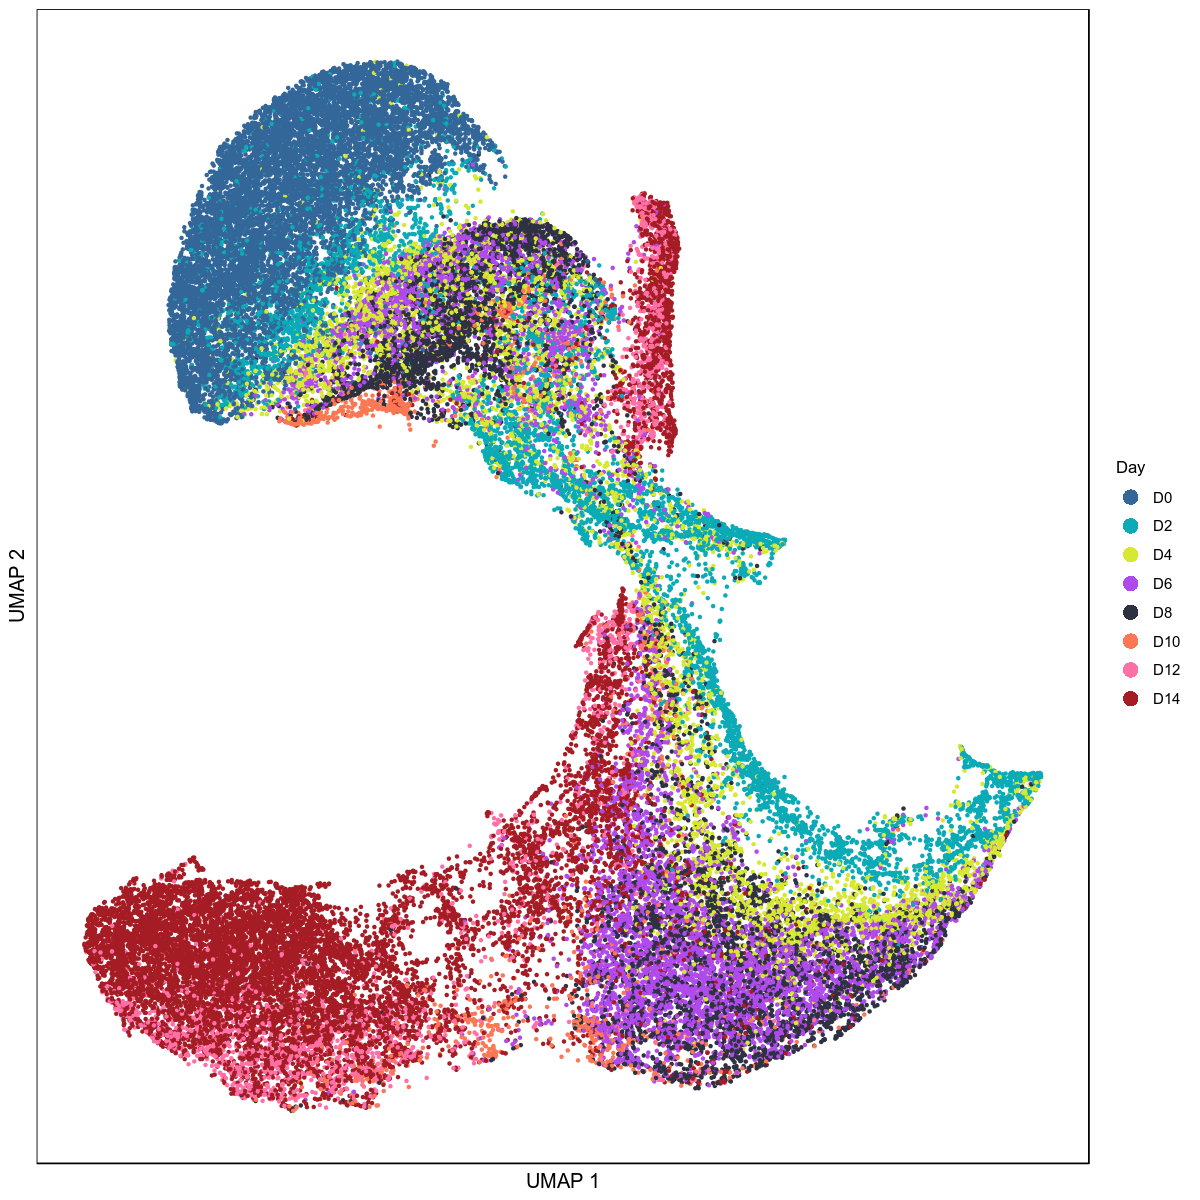

In [113]:
options(repr.plot.width = 10, repr.plot.height = 10)

day_col_vector1 = c("#336699", "#0AABB7", "#D6E82F", "#B14AED", "#2D3142", "#FC7753", "#FF70A6", "#A61C24")

df = data.frame(umap.1=nmat_umap[,1], #pcs[,1], 
                umap.2=nmat_umap[,2], #pcs[,2],
                sample=factor(x.sp@sample, levels=DAYS))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.6, alpha=1, aes(x=umap.1 , y=umap.2, col=sample)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=(day_col_vector1)) +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
                             override.aes = list(shape=16, alpha=1, size=4)))

## Visualization

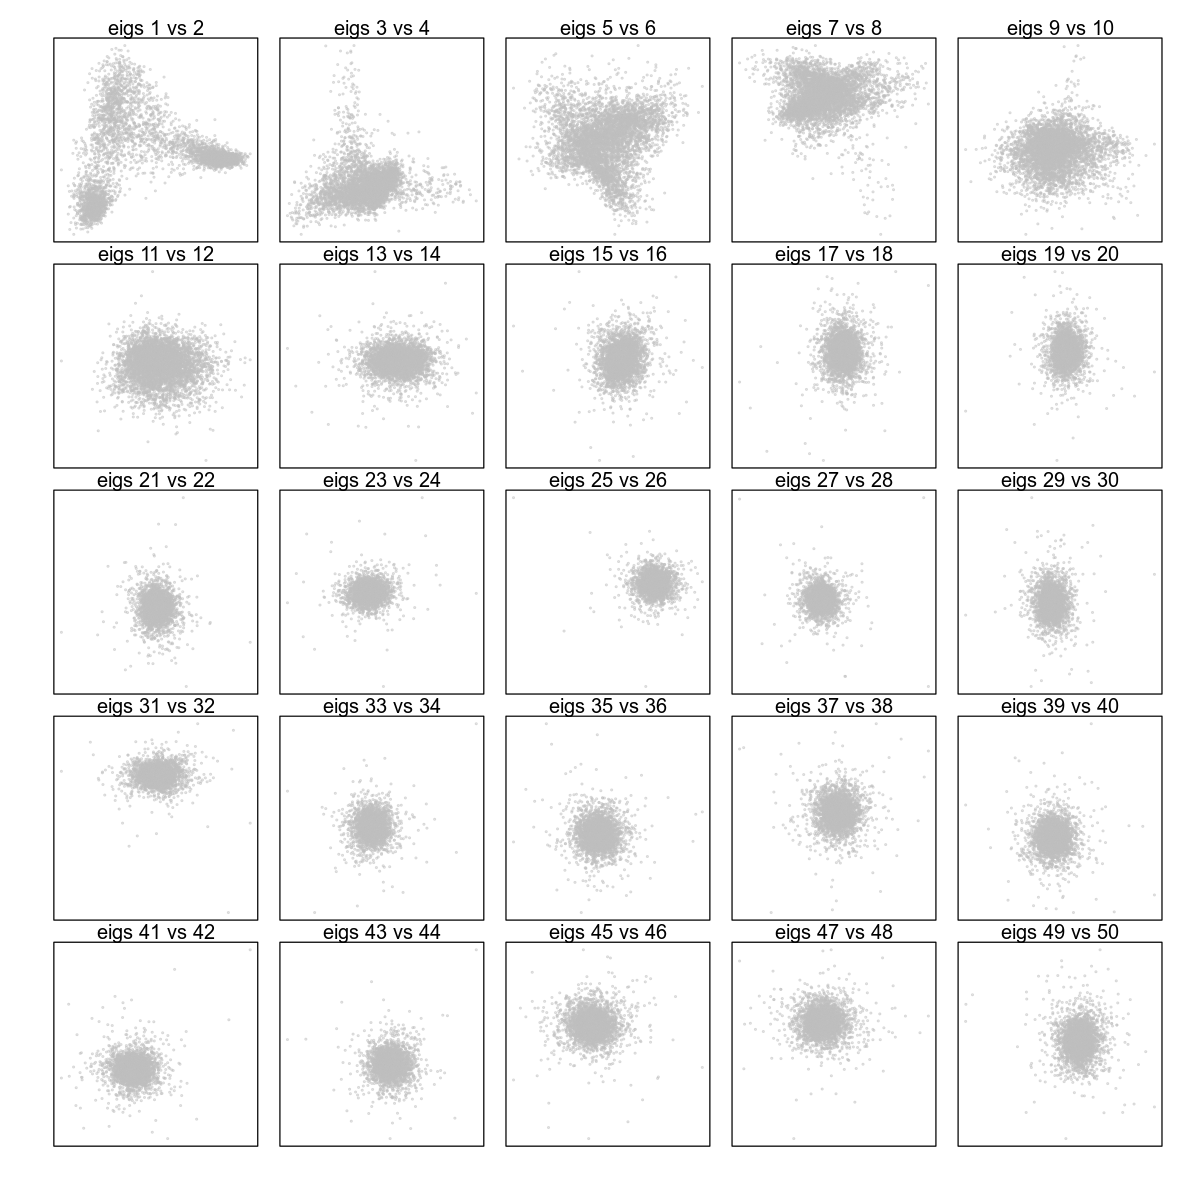

In [146]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [147]:
# library(leiden)

In [148]:
# table(x.sp@cluster)

In [149]:
x.sp = runKNN(
    obj= x.sp,
    eigs.dim=1:8,
    k=15
  );

In [150]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:8, 
    method="umap",
    seed.use=1,
    num.cores=10,
  );

In [151]:
dim(x.sp@umap)

[1] 53906     2

In [134]:
# write features- can use for Trajectory inference
# NUM_EIGS = 9
# df = data.frame(x.sp@sample, x.sp@umap, x.sp@cluster, x.sp@smat@dmat[,1:NUM_EIGS])
# rownames(df) = paste(x.sp@sample, x.sp@barcode, sep='_')
# write.table(df, "./sessions/20200220_n74838/features.tsv", 
#             sep='\t', quote = F, row.names = T)

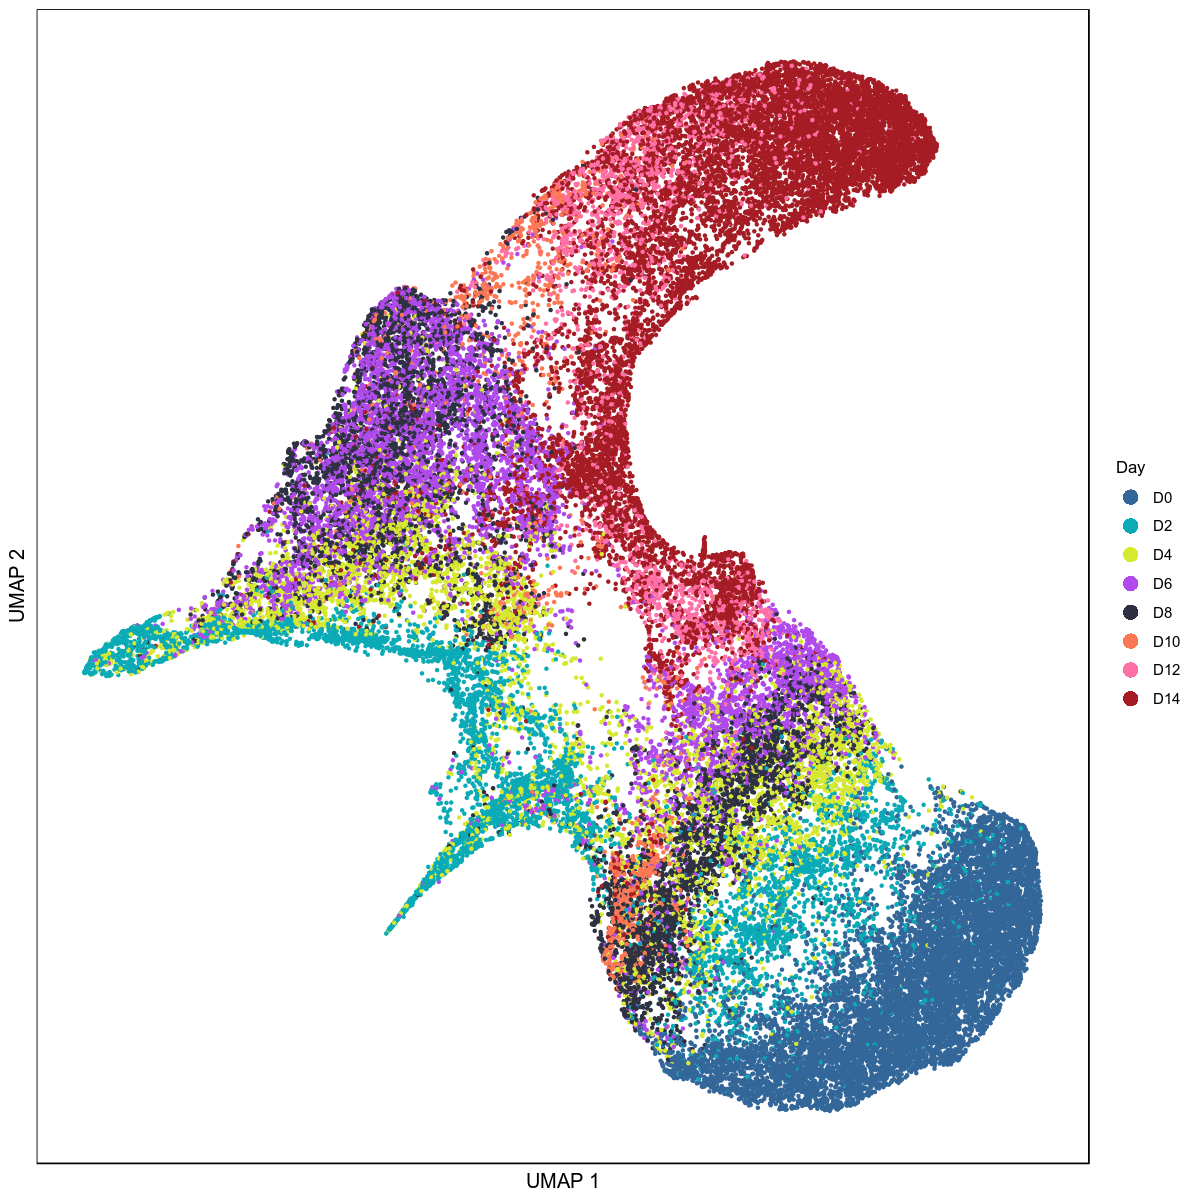

In [153]:
options(repr.plot.width = 10, repr.plot.height = 10)

day_col_vector1 = c("#336699", "#0AABB7", "#D6E82F", "#B14AED", "#2D3142", "#FC7753", "#FF70A6", "#A61C24")

# Set1 palette colours (without yellow)
day_col_vector2 = c('#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#BAF0DB', '#A65628', '#F781BF', '#E41A1C')

day_col_vector3 = c('#A87D6D', '#F28E6A', '#AE4527', '#A558AA', '#53DBA4', '#C5F9E4', '#AD87AF', '#EFBAB3')

# day_col_vector4 = col_vector[sample(length(col_vector), 8)]
day_col_vector4 = c('#984EA3','#F781BF','#FB8072','#A6761D','#1F78B4','#8DA0CB','#E7298A','#CBD5E8')

df = data.frame(x.sp@umap, sample=factor(x.sp@sample, levels=DAYS))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.6, alpha=1, aes(x=umap.1 , y=umap.2, col=sample)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=(day_col_vector1)) +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
                             override.aes = list(shape=16, alpha=1, size=4)))

In [160]:
# copy over cluster from previous iteration 
rownames(metadata) = paste(metadata$sample, metadata$barcode,sep='_')
x.sp@cluster = factor(metadata[paste(x.sp@sample, x.sp@barcode, sep='_'), "cluster"])
x.sp@metaData$cluster = x.sp@cluster

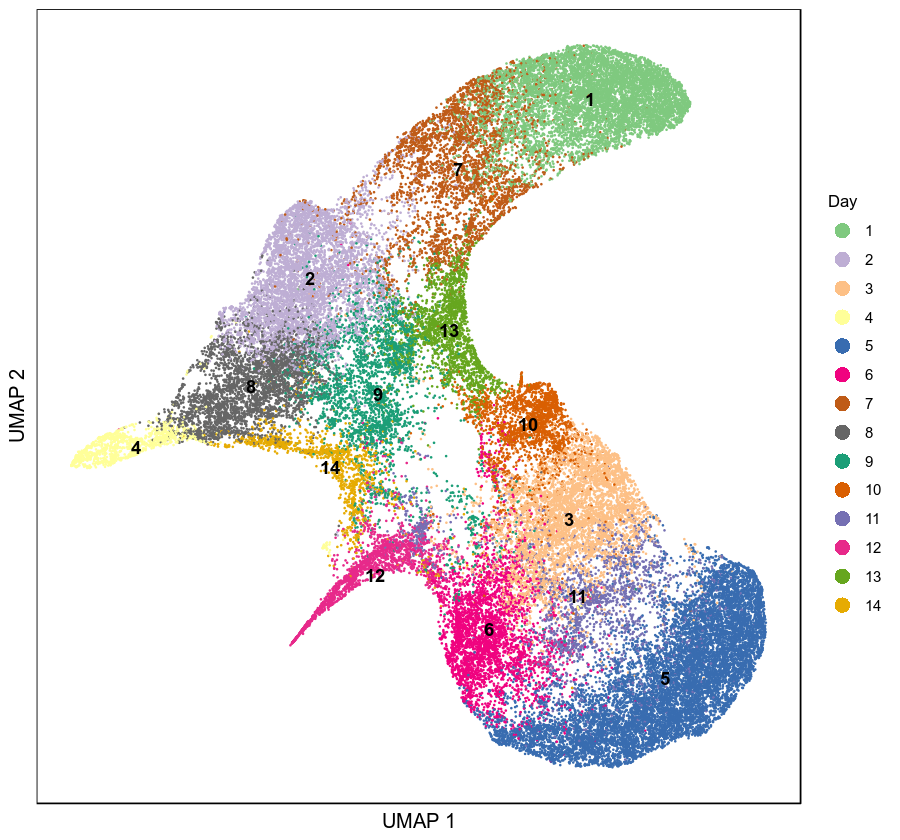

In [163]:
options(repr.plot.width = 7.5, repr.plot.height = 7)

df = data.frame(x.sp@umap, cluster=x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=cluster)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
                             override.aes = list(shape=16, alpha=1, size=4))) +
geom_text(data=data.frame(aggregate(x.sp@umap, list(x.sp@cluster), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold") 

In [424]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

# ggplot(df, 
ggplot(df[(df$x.sp.sample %in% c("D6","D8","D10", "D12")),], 
       aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.4, alpha=1) +
scale_colour_manual(values = col_vector[seq(45,74,1)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [ ]:
# TODO: clusters should be ordered such that similar ones are close in number and colour

# day-wise cluster membership + cluster-wise day membership
options(repr.plot.width = 13, repr.plot.height = 4)

sample_cluster_df = data.frame(sample=x.sp@sample, cluster=x.sp@cluster, count=1)

# count cells per sample x cluster
sample_cluster_cts = aggregate(.~sample+cluster, 
                               sample_cluster_df, 
                               sum)
# normalise per sample
sample_cts = aggregate(sample_cluster_df[,"count"], list(sample_cluster_df[,"sample"]), sum)
rownames(sample_cts) = sample_cts$Group.1
sample_cts$Group.1 = NULL

# frac of cluster per sample
sample_cluster_cts$frac_cluster = 100*sample_cluster_cts$count/sample_cts[sample_cluster_cts$sample, "x"]

# normalise per cluster
cluster_norm_cts = aggregate(sample_cluster_cts[,"frac_cluster"], list(sample_cluster_cts[,"cluster"]), sum)
rownames(cluster_norm_cts) = cluster_norm_cts$Group.1
cluster_norm_cts$Group.1 = NULL

# frac of day (after normalizing for number of cells per day) per sample
sample_cluster_cts$frac_day = 100*sample_cluster_cts$frac_cluster/cluster_norm_cts[sample_cluster_cts$cluster, "x"]

ggplot(data=sample_cluster_cts, aes(x=cluster, y=frac_day, fill=sample)) +
scale_fill_brewer(breaks=DAYS, palette = "Set1") +
geom_bar(stat="identity") +
ylab("Percent Cells") +
xlab("Cluster") +
guides(fill = guide_legend(ncol=1, title="Sample", pos="center")) +
theme(text = element_text(size=15))

# Stacked barplot with multiple groups
ggplot(data=sample_cluster_cts, aes(x=factor(sample, levels=DAYS), y=frac_cluster, fill=cluster)) +
scale_fill_manual(values = col_vector[seq(45,74,1)]) +
geom_bar(stat="identity") +
ylab("Percent Cells") +
xlab("Sample") +
guides(fill = guide_legend(ncol=2, title="Cluster", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))


In [ ]:
# Density plot

# options(repr.plot.width = 10, repr.plot.height = 10)

# df = data.frame(x.sp@umap, x.sp@sample)

# ggplot(df) +
# geom_point(shape=20, size=0.05, alpha=0.1, aes(x=umap.1 , y=umap.2)) +
# ggtitle("All Cells (Density)") + 
# theme(plot.title = element_text(hjust = 0.5))  

In [ ]:
table(x.sp@sample[x.sp@cluster=="11"])

In [95]:
# DOES NOT SEEM TO AGREE WITH NUMBERS IN PLOT PATH, WHICH SHOW ~30% FRAC IN PROM
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
prom.hg38 = promoters(genes(txdb), upstream = 2000, downstream = 0)
overlaps = findOverlaps(x.sp@peak, prom.hg38);
idy = queryHits(overlaps)
promoter_ratio = Matrix::rowSums(x.sp@pmat[,idy]) / Matrix::rowSums(x.sp@pmat);

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




In [96]:
quantile(promoter_ratio, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1))

0%        10%        25%        50%        75%        90%        99% 
0.01666667 0.04179440 0.04642520 0.05194385 0.06040424 0.07504078 0.10017084 
      100% 
0.15411559

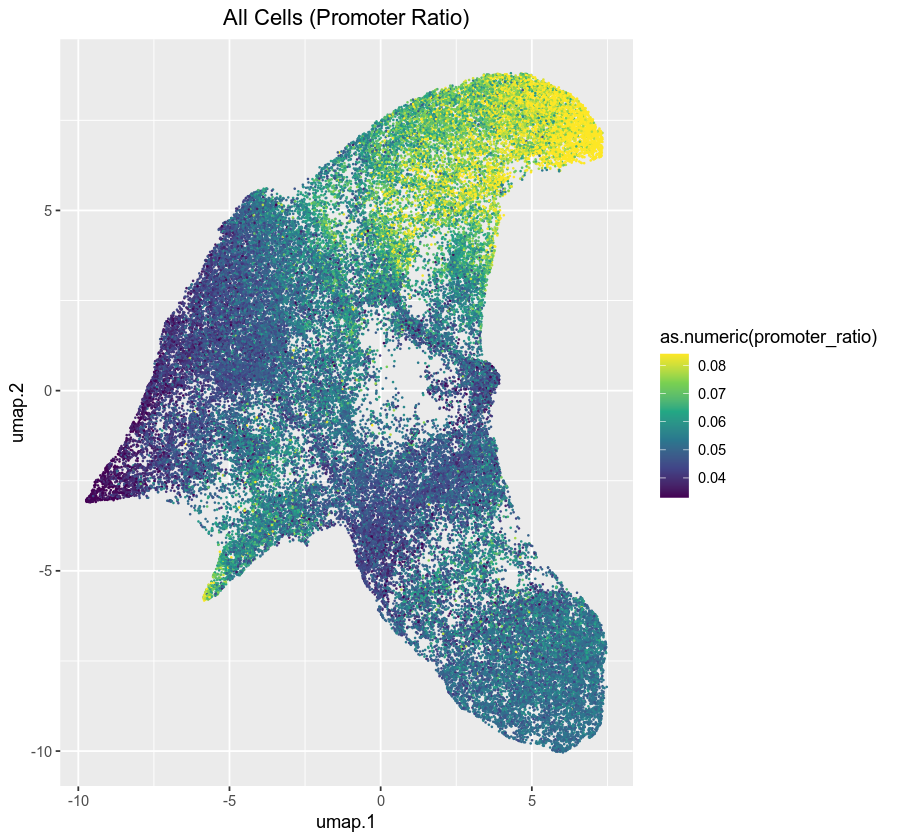

In [97]:
df = data.frame(x.sp@umap, promoter_ratio)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(promoter_ratio))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c(lim=c(quantile(promoter_ratio, 0.01),
                            quantile(promoter_ratio, 0.95)), 
                      oob=squish) +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])

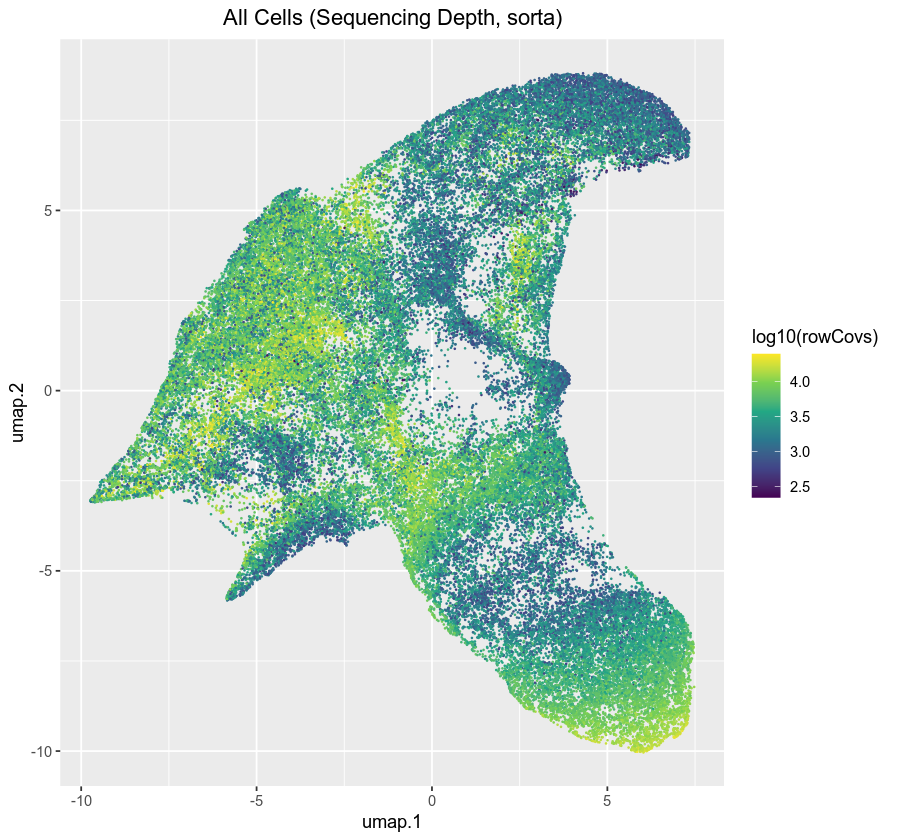

In [98]:
df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=log10(rowCovs))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth, sorta)") + 
theme(plot.title = element_text(hjust = 0.5)) 

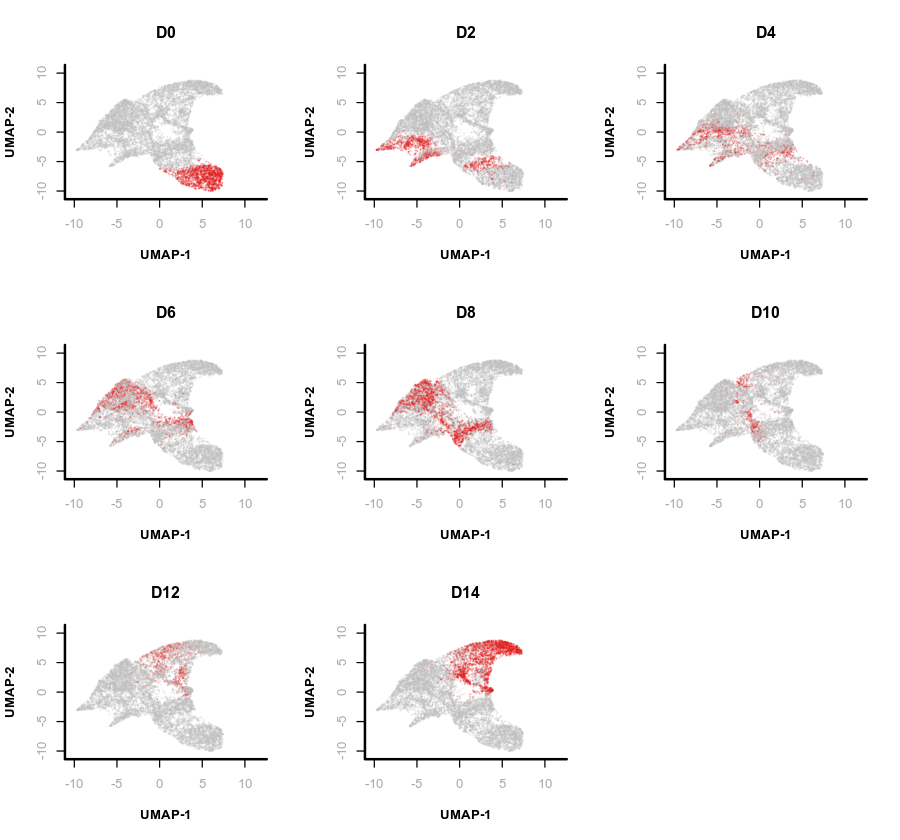

In [99]:
par(mfrow = c(3, 3));
for(d in DAYS){
  plotViz(
    obj=x.sp,
    method="umap", 
    main=d,
    point.color=x.sp@sample==d, 
    point.size=0.01,
    point.alpha=0.2,
    text.add= FALSE,
    down.sample=10000,
    legend.add=FALSE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );
}

## Export Meta Data for Session

In [154]:
x.sp

number of barcodes: 53906
number of bins: 0
number of genes: 0
number of peaks: 393750
number of motifs: 0

In [164]:
myExportMetaData <- function(obj, file, slot.names) {
    metaData.ls = lapply(as.list(slot.names), function(x){
        if(x == "barcode"){
            y = data.frame(slot(obj, x));
            colnames(y) = "barcode"
        }else if(x == "tsne"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("tsne1", "tsne2");
        }else if(x == "umap"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("umap1", "umap2");
        }else if(x == "cluster"){
            y = data.frame(slot(obj, x));
            colnames(y) = "cluster"
        }else if(x == "sample"){
            y = data.frame(slot(obj, x));
            colnames(y) = "sample"
        }else{
            y = data.frame(slot(obj, x));
        }
        y
    })
    
    if(!all(sapply(lapply(metaData.ls, nrow), FUN = identical, nrow(metaData.ls[[1]])))){
        stop("slot in subset.names have different length")
    }
    
    metaData.df = do.call(cbind, metaData.ls);

    write.table(metaData.df, file = file, append = FALSE, quote = FALSE, sep = "\t",
                eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                col.names = TRUE, qmethod = c("escape", "double"),
                fileEncoding = "")
}

myExportMetaData(x.sp, "./sessions/20201022_n53906/metadata.tsv", slot.names=c('barcode', 'sample', 'umap', 'cluster'))

In [165]:
# reload non-binarized
x.sp = addPmatToSnap(x.sp);

Epoch: reading cell-peak count matrix session ...



In [166]:
x.sp

number of barcodes: 53906
number of bins: 0
number of genes: 0
number of peaks: 414632
number of motifs: 0

In [167]:
black_list = read.table("../../../resources/blacklist/GRch38_unified_blacklist.bed");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [168]:
idy = queryHits(findOverlaps(x.sp@peak, black_list.gr));

In [169]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [170]:
x.sp

number of barcodes: 53906
number of bins: 0
number of genes: 0
number of peaks: 414473
number of motifs: 0

In [171]:
writeMM(x.sp@pmat, file="./sessions/20201022_n53906/pmat.sparse.mm")

NULL

In [172]:
write.table(data.frame(sample_barcode=paste(x.sp@sample, x.sp@barcode, sep='_'), x.sp@smat@dmat),
            "./sessions/20201022_n53906/features.50d.tsv", sep="\t", row.names= FALSE, col.names = T, quote = FALSE)
write.table(data.frame(sample_barcode=paste(x.sp@sample, x.sp@barcode, sep='_'), x.sp@smat@dmat[,1:8]),
            "./sessions/20201022_n53906/features.8d.tsv", sep="\t", row.names= FALSE, col.names = T, quote = FALSE)

In [173]:
# writing ranges
write.table(data.frame(seqnames=seqnames(x.sp@peak),
                       starts=start(x.sp@peak),
                       ends=end(x.sp@peak)),
            file="./sessions/20201022_n53906/peaks.bed",
            quote=F, sep="\t", row.names=F, col.names=F)

In [ ]:
# How to get the order in which a list A can be transformed to a list B 
# When both have same unique elements in them
# o(A)   o(B) o(o(B))   o(A)[o(o(B))] <---- that's what you need to do
# 3   ->  4     3           2
# 4   ->  2     2           4 
# 2   ->  1     4           1
# 1   ->  3     1           3

In [32]:
# metaData = read.table("./snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
# metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')

In [ ]:
# actual_sample_barcode = paste(x.sp.raw@sample, x.sp.raw@barcode, sep="_")

In [ ]:
# sort_order = order(actual_sample_barcode)[order(order(metaData$sample_barcode))]

In [ ]:
# all(actual_sample_barcode[sort_order] == metaData$sample_barcode)

In [42]:
# writeMM(x.sp.raw@bmat[sort_order, ], file="./snapATAC_sessions/20200125_n76770/5kb.full.mm")

NULL

## ChromVar

In [433]:
library(chromVAR)
library(motifmatchr)
library(SummarizedExperiment);
library(BSgenome.Hsapiens.UCSC.hg38);
# library(JASPAR2016)
library(JASPAR2018)
library(TFBSTools)



Loading required package: DelayedArray

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


Loading required package: BiocParallel


Attaching package: ‘DelayedArray’


The following objects are masked from ‘package:matrixStats’:

    colMaxs, colMins, colRanges, rowMaxs, rowMins, rowRanges


The following objects are masked from ‘package:base’:

    aperm, apply


Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:DelayedArray’:

    type


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer


Attaching package: ‘TFBSTools’


The following object is masked from ‘package:DelayedArray’:

    matrixClass


The following object is masked from ‘package:Matrix’:

    Matrix




In [434]:
opts <- list()
opts[["species"]] <- 9606
PFMatrixList <- getMatrixSet(JASPAR2018, opts)

In [435]:
PFMatrixList[[length(PFMatrixList)+1]] = readJASPARMatrix("./data/jaspar/MA0143.4.jaspar")

In [436]:
PFMatrixList

PFMatrixList of length 453
names(453): MA0025.1 MA0030.1 MA0031.1 MA0051.1 ... MA1419.1 MA1420.1 MA1421.1 

In [242]:
# updating getJasparMotifs, which is called by runChromVAR,
# so that it uses Jaspar2018 motifs
getJasparMotifs <- function (collection, species) {
    return(PFMatrixList)
}

In [ ]:
x.sp@mmat = runChromVAR(
    obj=x.sp,
    input.mat="pmat",
    genome=BSgenome.Hsapiens.UCSC.hg38,
    min.count=10,
    species="Homo sapiens"
  );

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.4, alpha=1) +
scale_colour_manual(values = col_vector[seq(45,74,1)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [ ]:
table(x.sp@sample[x.sp@cluster=="4"])

In [ ]:
# write outlier clusters if any
# write.table(x.sp@barcode[(x.sp@cluster=="15")&(x.sp@sample=="D10")], "./out/cluster15_barcode.txt", row.names=F, quote = F, col.names = F)

# barcode list without outliers
for (d in DAYS) {
    write.table(x.sp@barcode[(x.sp@sample==d)&(x.sp@cluster != "15")], 
                sprintf("./barcodeLists/20190220_exclude_clump/%s.barcodes.txt", d),
                row.names = F,
                quote = F,
                col.names = F)
}

In [ ]:
table(x.sp@cluster[x.sp@sample=="D2"])

In [ ]:
df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample, x.sp@mmat)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]
colnames(df) = c(colnames(df)[1:4], sub("::", ".", lapply(PFMatrixList, function(x) {return (x@name)})))

In [ ]:
colnames(df)[grep("CDX", colnames(df))]

In [ ]:
var(df[,"PRRX1"])

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(df,
# ggplot(df[df$x.sp.sample %in% c("D0", "D2", "D4"),], 
       aes(x=umap.1, y=umap.2, col=CDX1)) +
geom_point(size=0.4, alpha=1) +
scale_color_viridis_c(limit=c(-0.5,0.6), oob=squish) +
ggtitle("ChromVAR Deviance") + 
theme(plot.title = element_text(hjust = 0.5)) 

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df, aes(x=x.sp.cluster, y= FOS.JUN, fill=x.sp.cluster)) + 
    theme_classic() +
    geom_violin() + 
    xlab("cluster") +
    ylab("motif enrichment") + 
    ggtitle("Motif") +
    theme(
#           plot.margin = margin(5,1,5,1, "cm"),
          axis.text.x = element_text(angle = 90, hjust = 1),
          axis.ticks.x=element_blank(),
          legend.position = "none"
);

In [ ]:
max(by_cluster[,c("MA0668.1_NEUROD2")])-min(by_cluster[,c("MA0668.1_NEUROD2")])

In [ ]:
by_cluster = aggregate(x.sp@mmat,  list(x.sp@cluster), mean)

In [ ]:
max_for_cluster = by_cluster[,apply(by_cluster, 2, which.max)=="12"]
length(max_for_cluster)

In [ ]:
lapply(strsplit(colnames(max_for_cluster)[rev(order(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min)))], "_"), "[[", 2)[1:10]

In [ ]:
rev(sort(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min)))

In [ ]:
rev(sort(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, function (x) {rev(sort(x))[2]})))

## Write ChromVAR outputs

In [ ]:
df = data.frame(x.sp@sample, x.sp@cluster, x.sp@umap, x.sp@mmat)
rownames(df) = paste(x.sp@sample, x.sp@barcode, sep='_')
colnames(df) = c("sample", "cluster", "umap1", "umap2", sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [ ]:
dim(df)

In [ ]:
head(df)

In [ ]:
gz = gzfile("./sessions/20200220_n74838/chromvar.tsv.gz", "w")
write.table(df, gz, sep='\t', row.names = T, quote = F)
close(gz)

## Clustering with ChromVAR 

In [ ]:
library(umap)

In [ ]:
df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample, x.sp@mmat)
# shuffle so days don't overlap
colnames(df) = c(colnames(df)[1:4], sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [ ]:
head(df)

In [ ]:
chromvar.umap = umap(df[,5:ncol(df)])

In [ ]:
df = data.frame(chromvar.umap$layout, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.1, alpha=1, aes(x=X1 , y=X2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [ ]:
library(patchwork)

In [ ]:
df = data.frame(chromvar.umap$layout, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 10000), ]

plots = list()
for (i in seq(1,length(DAYS))) {    
    cur_df = data.frame(df, d = (df$x.sp.sample == DAYS[i]))
    p = ggplot(cur_df) +
    geom_point(size=0.1, alpha=1, aes(x=X1 , y=X2, col=d)) +
    ggtitle(DAYS[i]) + 
    theme(plot.title = element_text(hjust = 0.5),
         legend.position = "none") 
    # ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
    #                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))
    
    plots[[i]] = p
}

In [ ]:
wrap_plots(plots)

In [ ]:
df = data.frame(chromvar.umap$layout, x.sp@mmat)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]
colnames(df) = c(colnames(df)[1:2], sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [ ]:
colnames(df)[grep("TCF", colnames(df))]

In [ ]:
ggplot(df,
# ggplot(df[(df$x.sp.sample=="D2"),], 
       aes(x=X1, y=X2, col=TCF4)) +
geom_point(size=0.4, alpha=1) +
scale_color_viridis_c(limit=c(-0.5,0.5), oob=squish) +
# scale_color_viridis_c() +
ggtitle("ChromVAR Deviance") + 
theme(plot.title = element_text(hjust = 0.5)) 